<a href="https://colab.research.google.com/github/COS-IT-FLOWS/Impacts/blob/main/population.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install osgeo
!pip install matplotlib
!pip install numpy

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for osgeo
  Running setup.py clean for osgeo
Failed to build osgeo
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (osgeo)


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.4 MB/s eta 0:00:00


In [42]:
import rasterio
import rasterio.features
import geopandas as gpd
import numpy as np
import pandas as pd
from tabulate import tabulate

# Load the population count TIFF
with rasterio.open(r"/content/drive/MyDrive/Lowerbasin/unadj_bounding.tif") as src:
    count_array = src.read(1)  # Read the first band (assuming it's the population count)
    no_data_value = src.nodata  # Get the no-data value from the raster
    raster_crs = src.crs  # Get the CRS of the raster

# Load the boundary shapefile
boundary = gpd.read_file(r"/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp")

# Ensure the boundary is in the same CRS as the raster
boundary = boundary.to_crs(raster_crs)

# Print the CRS of the boundary
print("Boundary CRS:", boundary.crs)

# Print the CRS of the raster
print("Raster CRS:", raster_crs)

# Initialize a list to store results
results = []
total_population_sum = 0  # Initialize total population sum

# Iterate through each polygon in the boundary
for index, row in boundary.iterrows():
    geom = row.geometry

    # Create a mask for the current polygon
    mask = rasterio.features.rasterize(
        [(geom, 1)],
        out_shape=count_array.shape,
        transform=src.transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )

    # Apply the mask to the count array
    clipped_array = np.where(mask, count_array, np.nan)

    # Exclude no-data values from the sum
    total_population = np.nansum(clipped_array[clipped_array != no_data_value])

    # Round the total population to zero decimal places
    total_population_rounded = round(total_population)

    # Append the results to the list
    results.append({'Polygon_Name': row['name'], 'Population': total_population_rounded})  # Replace 'name' with the actual column name for polygon names

    # Add to the total population sum
    total_population_sum += total_population_rounded

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(tabulate(results_df, headers='keys', tablefmt='psql'))

# Print the total population across all polygons
print(f"\nTotal Population Count Across All Polygons: {total_population_sum}")

# Optionally, save the DataFrame to a CSV file
# results_df.to_csv(r"C:\Users\Dell\Desktop\Ezhikkara\Lowerbasin\population_by_polygon.csv", index=False)

Boundary CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Raster CRS: EPSG:4326
+----+-----------------------------------------+--------------+
|    | Polygon_Name                            |   Population |
|----+-----------------------------------------+--------------|
|  0 | Kochi                                   |       629488 |
|  1 | Kodassery                               |        24538 |
|  2 | Pariyaram                               |        31658 |
|  3 | Meloor                                  |        27432 |
|  4 | Koratty                                 |        43426 |
|  5 | Aloor                                   |        62543 |
|  6 | Chalakudy                               |        60719 |
|  7 | Kadukutty     

In [47]:
import rasterio
import rasterio.mask
import geopandas as gpd
import numpy as np
import pandas as pd
from tabulate import tabulate
import os

def clip_raster_and_count_population(thresholds, elevation_shp_path_template, boundary_shp_path, raster_path, output_dir):
    # Load the boundary shapefile
    boundary = gpd.read_file(boundary_shp_path)

    # Initialize a list to store results
    results = []

    for threshold in thresholds:
        # Create the elevation shapefile path using the current threshold
        elevation_shp_path = elevation_shp_path_template.format(threshold=threshold)

        # Load the elevation shapefile for the current threshold
        elevation_shp = gpd.read_file(elevation_shp_path)

        # Ensure the boundary is in the same CRS as the elevation shapefile
        boundary = boundary.to_crs(elevation_shp.crs)

        # Clip the population raster using the elevation shapefile
        with rasterio.open(raster_path) as src:
            # Mask the raster with the elevation polygons
            clipped_raster, clipped_transform = rasterio.mask.mask(src, elevation_shp.geometry, crop=True, nodata=src.nodata)
            clipped_meta = src.meta.copy()
            clipped_meta.update({
                "driver": "GTiff",
                "height": clipped_raster.shape[1],
                "width": clipped_raster.shape[2],
                "transform": clipped_transform
            })

            # Save the clipped raster to the specified output directory
            clipped_raster_path = os.path.join(output_dir, f"clipped_population_{threshold}.tif")
            with rasterio.open(clipped_raster_path, "w", **clipped_meta) as dest:
                dest.write(clipped_raster)

        # Count population within each polygon in the boundary shapefile
        with rasterio.open(clipped_raster_path) as clipped_src:
            count_array = clipped_src.read(1)  # Read the clipped population data
            no_data_value = clipped_src.nodata  # Get the no-data value from the clipped raster

            # Iterate through each polygon in the boundary
            for index, row in boundary.iterrows():
                geom = row.geometry

                # Create a mask for the current polygon
                mask = rasterio.features.rasterize(
                    [(geom, 1)],
                    out_shape=count_array.shape,
                    transform=clipped_src.transform,
                    fill=0,
                    all_touched=True,
                    dtype='uint8'
                )

                # Apply the mask to the count array
                masked_array = np.where(mask, count_array, np.nan)

                # Exclude no-data values from the sum
                total_population = np.nansum(masked_array[masked_array != no_data_value])

                # Round the total population to zero decimal places
                total_population_rounded = round(total_population)
                # Accumulate the total population for this threshold
                # total_population_sum += total_population_rounded

                # Append the results to the list
                results.append({
                    'Polygon_Name': row['name'],
                    'Total_Population': total_population_rounded,
                    'Threshold': threshold
                })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Print the results DataFrame
    print(tabulate(results_df, headers='keys', tablefmt='psql'))
    # print(f"\nTotal Population Count Across All Polygons: {total_population_rounded}")
    # Save the DataFrame to a CSV file in the specified output directory
    # results_df.to_csv(os.path.join(output_dir, "population_by_polygon.csv"), index=False)

# Example usage
thresholds = [3.0]  # Define your thresholds
elevation_shp_path_template = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/{threshold}poly_lower.shp"  # Template for elevation shapefile paths
boundary_shp_path = "/content/drive/MyDrive/Lowerbasin/lower_basin_lsg_panchayat.shp"  # Path to boundary shapefile
raster_path = "/content/drive/MyDrive/Lowerbasin/unadj_bounding.tif"  # Path to the raster file
output_dir = "/content/drive/MyDrive/Lowerbasin/clipped_pop"  # Directory to save output files

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Run the function
clip_raster_and_count_population(thresholds, elevation_shp_path_template, boundary_shp_path, raster_path, output_dir)


+----+-----------------------------------------+--------------------+-------------+
|    | Polygon_Name                            |   Total_Population |   Threshold |
|----+-----------------------------------------+--------------------+-------------|
|  0 | Kochi                                   |             428571 |           3 |
|  1 | Kodassery                               |                 57 |           3 |
|  2 | Pariyaram                               |                 94 |           3 |
|  3 | Meloor                                  |                776 |           3 |
|  4 | Koratty                                 |                 32 |           3 |
|  5 | Aloor                                   |                561 |           3 |
|  6 | Chalakudy                               |                995 |           3 |
|  7 | Kadukutty                               |                471 |           3 |
|  8 | Annamanada                              |               2983 |       

<ipython-input-30-ba5ffbfd7521>:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


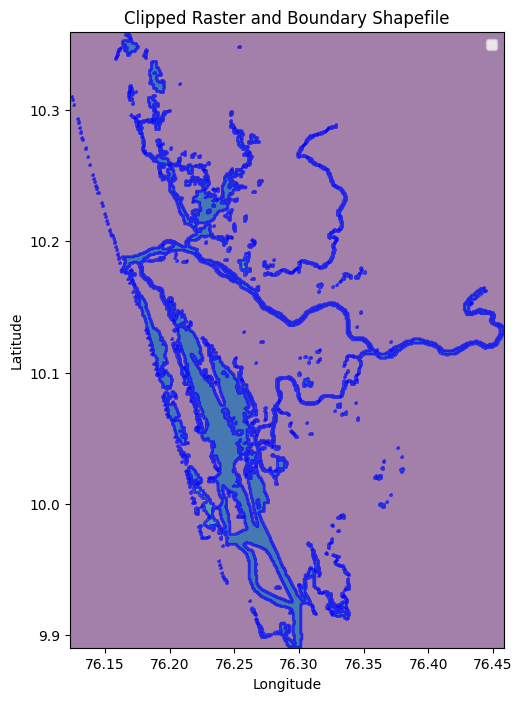

In [30]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt

def load_and_display(clipped_raster_path, boundary_shp_path):
    # Load the clipped raster
    with rasterio.open(clipped_raster_path) as src:
        clipped_raster = src.read(1)  # Read the first band
        raster_transform = src.transform  # Get the transform for the raster

    # Load the boundary shapefile
    boundary = gpd.read_file(boundary_shp_path)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the clipped raster
    rasterio.plot.show(clipped_raster, transform=raster_transform, ax=ax, cmap='viridis', alpha=0.5)

    # Plot the boundary shapefile
    boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='Boundary', alpha=0.7)

    # Set the title and labels
    ax.set_title("Clipped Raster and Boundary Shapefile")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Set the background color to transparent
    ax.set_facecolor('none')  # Set the axis background to transparent

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

# Example usage
clipped_raster_path = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/clipped_population_1.0.tif"  # Path to the clipped raster
boundary_shp_path = "/content/drive/MyDrive/Lowerbasin/EXTRACTED_FILES/1.0poly_lower.shp"  # Path to the boundary shapefile

# Call the function to load and display
load_and_display(clipped_raster_path, boundary_shp_path)